In [40]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub

In [41]:
(train_set, validation_set), info = tfds.load(
    'tf_flowers',
    with_info = True,
    as_supervised = True,
    split=['train[:70%]', 'train[70%:]'],
)

In [42]:
num_classes = info.features['label'].num_classes
num_examples = info.splits['train'].num_examples
num_train_examples = num_examples*0.7
num_validation_examples = num_examples*0.3

print('Num classes is {}'.format(num_classes))
print('Num traing set is {}'.format(num_train_examples))
print('Num validation set is {}'.format(num_validation_examples))

Num classes is 5
Num traing set is 2569.0
Num validation set is 1101.0


In [ ]:
for i, image in enumerate(train_set):
  print('image {} shape: {}, label: {}'.format(i, image[0].shape, image[1]))

In [44]:
image_size = 299
def format_image(image, label):
  image = tf.image.resize(image, (image_size, image_size))/255
  return image, label

In [45]:
batch_size = 32
train_batch = train_set.shuffle(int(num_train_examples)).map(format_image).batch(batch_size).prefetch(1)
val_batch = validation_set.map(format_image).batch(batch_size).prefetch(1)

In [46]:
URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape = (image_size, image_size, 3))

In [47]:
feature_extractor.trainable=False

In [48]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(5, activation = 'softmax')
])

In [49]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [50]:
epochs = 6
history = model.fit(
    train_batch,
    epochs = epochs,
    validation_data = val_batch,
    
)

Epoch 1/6
81/81 [==============================] - 21s 202ms/step - loss: 0.7686 - accuracy: 0.7264 - val_loss: 0.4614 - val_accuracy: 0.8538
Epoch 2/6
81/81 [==============================] - 13s 166ms/step - loss: 0.3981 - accuracy: 0.8770 - val_loss: 0.3536 - val_accuracy: 0.8883
Epoch 3/6
81/81 [==============================] - 14s 168ms/step - loss: 0.3117 - accuracy: 0.9011 - val_loss: 0.3329 - val_accuracy: 0.8792
Epoch 4/6
81/81 [==============================] - 13s 165ms/step - loss: 0.2621 - accuracy: 0.9179 - val_loss: 0.3022 - val_accuracy: 0.8937
Epoch 5/6
81/81 [==============================] - 13s 162ms/step - loss: 0.2337 - accuracy: 0.9272 - val_loss: 0.3020 - val_accuracy: 0.8910
Epoch 6/6
81/81 [==============================] - 13s 164ms/step - loss: 0.2060 - accuracy: 0.9455 - val_loss: 0.2697 - val_accuracy: 0.8955


Text(0.5, 1.0, 'loss')

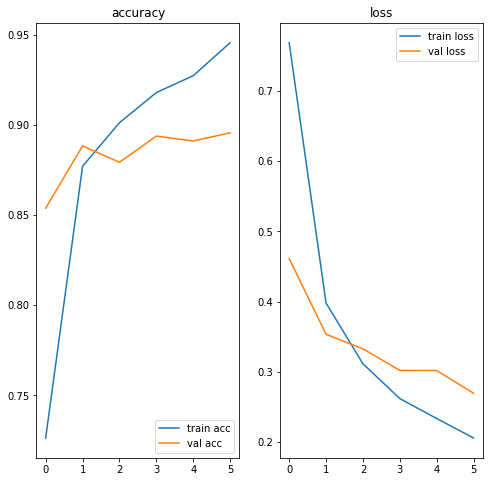

In [51]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label='train acc')
plt.plot(epoch_range, val_acc, label='val acc')
plt.legend(loc='lower right')
plt.title('accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label='train loss')
plt.plot(epoch_range, val_loss, label='val loss')
plt.legend(loc='upper right')
plt.title('loss')

In [52]:
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [53]:
images_batch, labels_batch = next(iter(train_batch.take(1)))
images_batch = images_batch.numpy()
labels_batch = labels_batch.numpy()

predicted_batch = model.predict(images_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_idx = np.argmax(predicted_batch, axis=-1)
predicted_class = class_names[predicted_idx]
predicted_class

1/1 [==============================] - 1s 648ms/step


array(['dandelion', 'sunflowers', 'roses', 'tulips', 'sunflowers',
       'tulips', 'roses', 'dandelion', 'tulips', 'dandelion', 'roses',
       'sunflowers', 'roses', 'roses', 'dandelion', 'daisy', 'dandelion',
       'tulips', 'sunflowers', 'sunflowers', 'tulips', 'tulips', 'roses',
       'roses', 'sunflowers', 'dandelion', 'dandelion', 'daisy', 'roses',
       'dandelion', 'tulips', 'sunflowers'], dtype='<U10')

In [25]:
print(labels_batch)
print(predicted_class)

[0 4 0 2 0 0 2 0 2 1 0 1 2 1 3 2 3 2 4 1 1 1 3 1 4 2 1 3 2 4 4 0]
['dandelion' 'roses' 'dandelion' 'tulips' 'dandelion' 'dandelion' 'tulips'
 'dandelion' 'tulips' 'daisy' 'dandelion' 'daisy' 'tulips' 'daisy'
 'sunflowers' 'tulips' 'sunflowers' 'tulips' 'roses' 'daisy' 'dandelion'
 'daisy' 'sunflowers' 'daisy' 'roses' 'tulips' 'daisy' 'sunflowers'
 'tulips' 'roses' 'roses' 'dandelion']


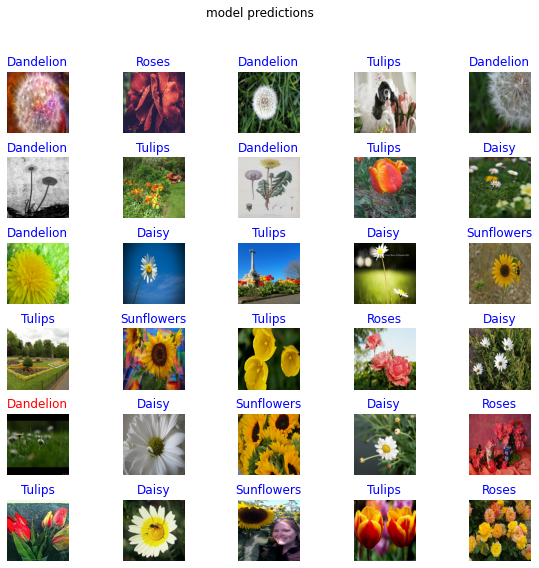

In [30]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.4)
  plt.imshow(images_batch[n])
  color = 'blue' if predicted_idx[n]==labels_batch[n] else 'red'
  plt.title(predicted_class[n].title(), color=color)
  plt.axis('off')
  plt.suptitle('model predictions')